<a href="https://colab.research.google.com/github/Sage-Kase/CANIS/blob/main/CANISHackathonYoutubeDataCompiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and Package Prep

In [22]:
#@title Package Imports ad Data Prep
import pandas as pd
import math
import tweepy
!pip install colab-env --upgrade
import os
import colab_env
from dotenv import load_dotenv, find_dotenv
url = "https://www.kaggle.com/datasets/26d46af7be53af51e042cf9abc377731d0d53faec0a4cf713ffbf5dca3c364dc"
full_file = pd.read_excel('/content/CANIS_PRC_state_media_on_social_media_platforms-2023-11-03.xlsx')
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
!pip install --upgrade google-api-python-client
!pip install --upgrade google-auth-oauthlib google-auth-httplib2
!pip install selenium webdriver-manager
import matplotlib.dates as mdates
!pip install datetime
import datetime

In [4]:
# Code to get all lines from News outlets with a youtube account

indices = [i for i in range(len(full_file)) if isinstance(full_file['YouTube account'][i], str)]
overall_dict = {}
for index in indices:
  overall_dict[full_file['Name (English)'][index]] = [full_file['Language'][index],
                                                      full_file['Region of Focus'][index],
                                                      full_file['Parent entity (English)'][index],
                                                      full_file['Entity owner (English)'][index],
                                                      full_file['YouTube account'][index]]


159

## Getting All Video Data

In [6]:
from googleapiclient.discovery import *
from google.colab import userdata

api_key = userdata.get('apikey9')
channel_id = full_file['YouTube account'][indices[1]]
youtube = build('youtube', 'v3', developerKey=api_key)

In [ ]:
#@title Function to get a specific channel's Info
def get_channel_stats(youtube, channel_id):
  request = youtube.channels().list(id=channel_id,part="snippet,contentDetails,statistics")
  response = request.execute()
  data = dict(Channel_name = response['items'][0]['snippet']['title'], playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads'])
  return data

In [ ]:
#@title Function to get video IDs from a specific channel
def get_video_ids(youtube, playlist_id):
  request = youtube.playlistItems().list(
      part='contentDetails',
      playlistId = playlist_id, maxResults = 50)
  response = request.execute()

  video_ids = []
  for i in range(len(response['items'])):
    video_ids.append(response['items'][i]['contentDetails']['videoId'])

  next_page_token = response.get('nextPageToken')
  more_pages = True

  while more_pages:
    if next_page_token is None:
      more_pages = False
    else:
      request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId = playlist_id, maxResults = 50, pageToken = next_page_token)
      response = request.execute()

      for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

      next_page_token = response.get('nextPageToken')
  return video_ids

In [ ]:
#@title Function to get video details (Publish Time and Views) given the video id
def get_video_details(youtube, video_ids):
  all_video_stats = []

  for i in range(0, len(video_ids), 50):
    request = youtube.videos().list(part='snippet,statistics',id=','.join(video_ids[i:i+50]))
    response = request.execute()

    for video in response['items']:
      video_stats = dict(Published_date = video['snippet']['publishedAt'], Views = video['statistics']['viewCount'])
      all_video_stats.append(video_stats)
  return all_video_stats

In [ ]:
#@title For all the available channels, gets all the posted videos and their posted time/view count
for channels in overall_dict:
  if requests.get('https://www.googleapis.com/youtube/v3/search?part=id&q=' + overall_dict[channels][4] + '&type=channel&key=' + api_key).json()['items'] == []:
    pass
  else:
    try:
     current_channel_id = requests.get('https://www.googleapis.com/youtube/v3/search?part=id&q=' + overall_dict[channels][4] + '&type=channel&key=' + api_key).json()['items'][0]['id']['channelId']
    except:
      print(channels_left4[channels])
    try:
      all_uploads = get_channel_stats(youtube, current_channel_id)['playlist_id']
    except:
      print(channels_left4[channels])
    try:
      video_ids = get_video_ids(youtube, all_uploads)
    except:
      print(channels_left4[channels])
    try:
      video_details = get_video_details(youtube, video_ids)
    except:
      print(channels_left4[channels])
    overall_dict[channels].append(video_details)

In [ ]:
# Storage of this file for future runtimes
import pickle
with open('overall_so_far.pkl', 'wb') as f:
   pickle.dump(overall_dict, f)


# Creating Graphs with Data

In [7]:
# Load of this file from past runtimes
import pickle
with open('overall_so_far7.pkl', 'rb') as f:
   mynewlist = pickle.load(f)

overall_dict = mynewlist


In [ ]:
#@title Loading all the data into a pandas dataframe and postprocessing
data = []
for news_org in overall_dict:
  if len(overall_dict[news_org]) == 6:
    data += overall_dict[news_org][5]
len(data)
video_details = pd.DataFrame(data)

video_data = pd.DataFrame(video_details)
video_data['Published date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
print(video_data)
s = video_data['Published date'].value_counts().sort_index()
s

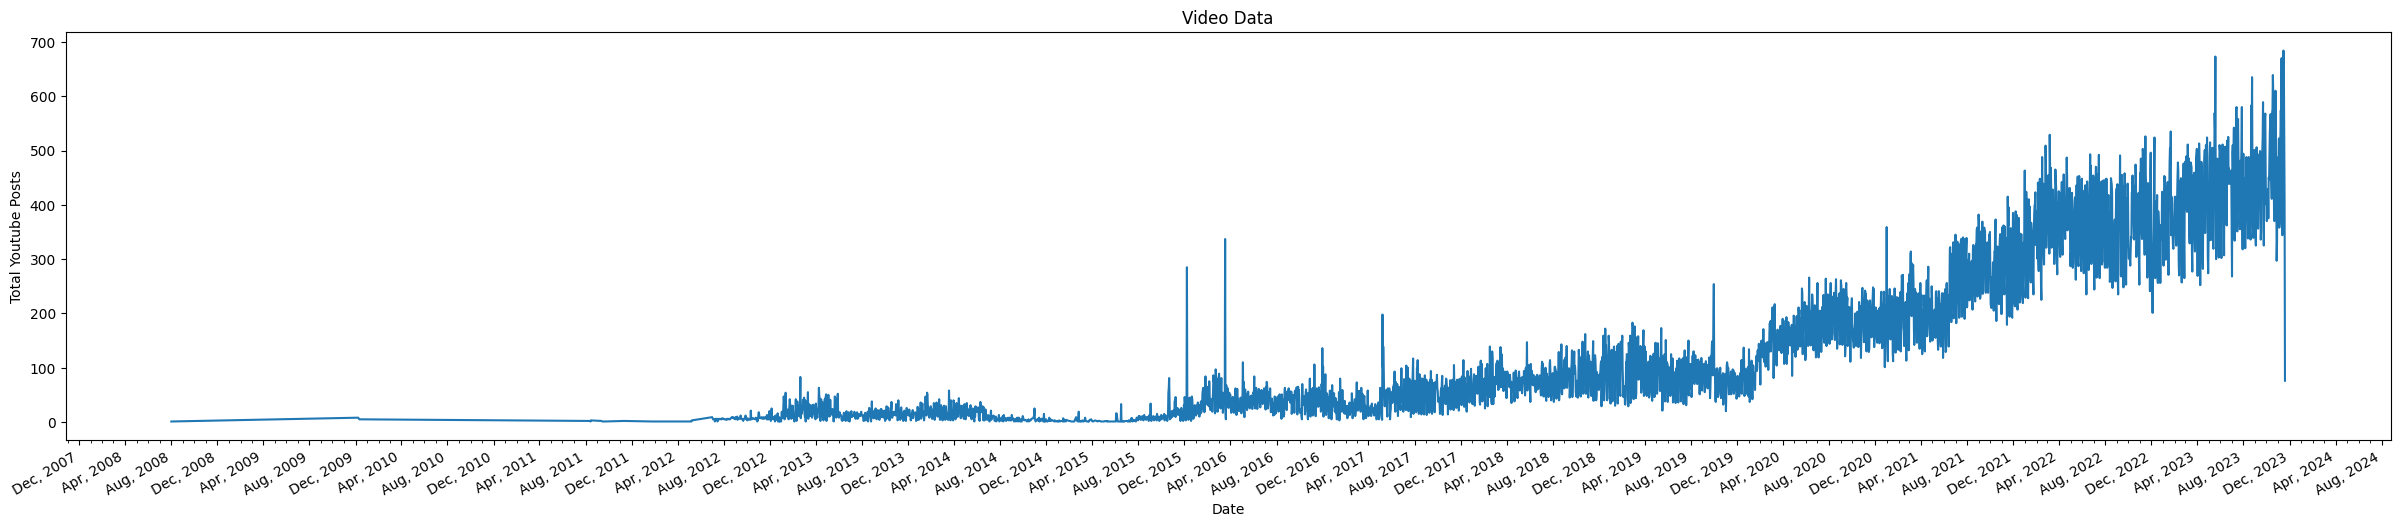

In [21]:
#@title Run to graph the data
date = s.keys()
value = s.values
fig, ax = plt.subplots(figsize=(30, 6))

# half_year_locator = mdates.MonthLocator(interval=4)
# ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.

half_year_locator = mdates.MonthLocator(interval=4)
# year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
monthly_locator = mdates.MonthLocator()
month_year_formatter = mdates.DateFormatter('%b, %Y')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
plt.xlabel("Date")
plt.ylabel("Total Youtube Posts")
plt.title('Video Data')

ax.plot(date, value)
fig.autofmt_xdate()
# Rotates and right aligns the x labels.
# Also moves the bottom of the axes up to make room for them.

#s.plot(xlabel='Date', ylabel='Number of Videos', label='Series')

### Facebook Attempt (Fail)

In [ ]:
# Attempted to get facebook data, but got shadow banned (see following output when requesting valid post data)
# WARNING:facebook_scraper.page_iterators:No raw posts (<article> elements) were found in this page.
# WARNING:facebook_scraper.page_iterators:No raw posts (<article> elements) were found in this page.

import warnings
warnings.filterwarnings("ignore")
set_user_agent("Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)")
# for post in get_posts('nintendo', pages=1, cookies='/content/www.facebook.com_cookies.txt'):
#      print(post['text'][:50])
# posts = get_posts(profile, cookies='/content/www.facebook.com_cookies.txt')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for index in indices:
      list_of_times = []
      try:
        for post in get_posts(full_file['Facebook page'][index], pages = 5, cookies='/content/nirucookies.txt', options={"posts_per_page": 200}):
          list_of_times.append(post['time'])
          overall_dict[full_file['Name (English)']].append(list_of_times)
      except:
          print('bad_data')

# get_profile('zuck', cookies='/content/www.facebook.com_cookies.txt')

bad_data
bad_data
bad_data
bad_data
